In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pydot

In [2]:
def get_data(filename, weekday):
    df = pd.read_csv(filename, sep=";", parse_dates=["timestamp"])
    df["weekday"] = weekday
    return df

In [3]:
monday = get_data("./data/monday.csv", "monday")
tuesday = get_data("./data/tuesday.csv", "tuesday")
wednesday = get_data("./data/wednesday.csv", "wednesday")
thursday = get_data("./data/thursday.csv", "thursday")
friday = get_data("./data/friday.csv", "friday")

In [4]:
def new_customer_no(df, weekday):
    df["customer_no"] = df["customer_no"].astype(str) + "_" + weekday

In [5]:
new_customer_no(monday, "monday")
new_customer_no(tuesday, "tuesday")
new_customer_no(wednesday, "wednesday")
new_customer_no(thursday, "thursday")
new_customer_no(friday, "friday")

In [6]:
monday

,timestamp,customer_no,location,weekday
0,2019-09-02 07:03:00,1_monday,dairy,monday
1,2019-09-02 07:03:00,2_monday,dairy,monday
2,2019-09-02 07:04:00,3_monday,dairy,monday
3,2019-09-02 07:04:00,4_monday,dairy,monday
4,2019-09-02 07:04:00,5_monday,spices,monday
...,...,...,...,...
4879,2019-09-02 21:49:00,1442_monday,checkout,monday
4880,2019-09-02 21:49:00,1444_monday,checkout,monday
4881,2019-09-02 21:49:00,1445_monday,dairy,monday
4882,2019-09-02 21:50:00,1446_monday,dairy,monday


In [7]:
def add_missing_checkout_location(df):
    checkout_customers = df[df["location"] == "checkout"]["customer_no"].unique()
    whole_customers = df["customer_no"].unique()
    diff = set(whole_customers).difference(checkout_customers)
    new_timestamp = df["timestamp"].max() + pd.DateOffset(hours=2)
    missing_checkouts = pd.DataFrame({"timestamp": [new_timestamp] * len(diff),"customer_no": list(diff),"location": ["checkout"] * len(diff), "weekday":df["weekday"][0]})
    df = pd.concat([df, missing_checkouts], ignore_index=True)
    return df

In [8]:
monday = add_missing_checkout_location(monday)
tuesday = add_missing_checkout_location(tuesday)
wednesday = add_missing_checkout_location(wednesday)
thursday = add_missing_checkout_location(thursday)
friday = add_missing_checkout_location(friday)

In [9]:
def add_entrance_state(df):
    min_datetime = df.groupby("customer_no")["timestamp"].min().reset_index()
    one_minute = datetime.timedelta(minutes=1)
    entrance_entries = min_datetime.apply(lambda x: {"timestamp": x["timestamp"] - one_minute, "customer_no": x["customer_no"], "location": "entrance"}, axis=1)
    entrance_entries = pd.DataFrame(list(entrance_entries))
    df = pd.concat([df, entrance_entries], ignore_index=True)
    return df

In [10]:
monday = add_entrance_state(monday)
tuesday = add_entrance_state(tuesday)
wednesday = add_entrance_state(wednesday)
thursday = add_entrance_state(thursday)
friday = add_entrance_state(friday)

In [11]:
monday

,timestamp,customer_no,location,weekday
0,2019-09-02 07:03:00,1_monday,dairy,monday
1,2019-09-02 07:03:00,2_monday,dairy,monday
2,2019-09-02 07:04:00,3_monday,dairy,monday
3,2019-09-02 07:04:00,4_monday,dairy,monday
4,2019-09-02 07:04:00,5_monday,spices,monday
...,...,...,...,...
6336,2019-09-02 17:42:00,997_monday,entrance,NaN
6337,2019-09-02 17:42:00,998_monday,entrance,NaN
6338,2019-09-02 17:43:00,999_monday,entrance,NaN
6339,2019-09-02 07:55:00,99_monday,entrance,NaN


In [12]:
def make_Df_proper(comming_data):
    df = pd.concat(comming_data, ignore_index=True)
    df.set_index("timestamp", inplace=True)
    df.sort_index(inplace=True)
    df=df[['customer_no', 'location']]
    df.rename(columns={'location': 'location0'}, inplace=True)
    return df

In [13]:
weekly_data_matrix=make_Df_proper([monday, tuesday, wednesday, thursday, friday])
weekly_data_matrix

,customer_no,location0
timestamp,,
2019-09-02 07:02:00,2_monday,entrance
2019-09-02 07:02:00,1_monday,entrance
2019-09-02 07:03:00,1_monday,dairy
2019-09-02 07:03:00,4_monday,entrance
2019-09-02 07:03:00,3_monday,entrance
...,...,...
2019-09-06 23:50:00,1505_friday,checkout
2019-09-06 23:50:00,1494_friday,checkout
2019-09-06 23:50:00,1500_friday,checkout


In [14]:
weekly_data_matrix=weekly_data_matrix.groupby("customer_no")[["location0"]].resample(rule="3min").ffill()
weekly_data_matrix.reset_index(inplace=True)
weekly_data_matrix["location1"] =weekly_data_matrix.groupby("customer_no")["location0"].shift(-1)

weekly_data_matrix["location0"].fillna("entrance", inplace=True)
weekly_data_matrix["location1"].fillna("checkout", inplace=True)

In [15]:
weekly_data_matrix[weekly_data_matrix["customer_no"] == "1002_monday"]

,customer_no,timestamp,location0,location1
50,1002_monday,2019-09-02 17:42:00,entrance,drinks
51,1002_monday,2019-09-02 17:45:00,drinks,checkout
52,1002_monday,2019-09-02 17:48:00,checkout,checkout


In [16]:
weekly_data_matrix[weekly_data_matrix["customer_no"] == "1000_monday"]

,customer_no,timestamp,location0,location1
1,1000_monday,2019-09-02 17:42:00,entrance,dairy
2,1000_monday,2019-09-02 17:45:00,dairy,dairy
3,1000_monday,2019-09-02 17:48:00,dairy,checkout
4,1000_monday,2019-09-02 17:51:00,checkout,checkout


In [17]:

weekly_data_matrix.fillna("checkout", inplace=True)

In [18]:
#weekly_data_matrix.to_csv("./simulated_market_table")
weekly_data_matrix

,customer_no,timestamp,location0,location1
0,1000_friday,2019-09-06 17:18:00,entrance,checkout
1,1000_monday,2019-09-02 17:42:00,entrance,dairy
2,1000_monday,2019-09-02 17:45:00,dairy,dairy
3,1000_monday,2019-09-02 17:48:00,dairy,checkout
4,1000_monday,2019-09-02 17:51:00,checkout,checkout
...,...,...,...,...
26481,9_tuesday,2019-09-03 07:24:00,dairy,dairy
26482,9_tuesday,2019-09-03 07:27:00,dairy,checkout
26483,9_tuesday,2019-09-03 07:30:00,checkout,checkout
26484,9_wednesday,2019-09-04 07:00:00,entrance,spices


In [19]:
transition_=pd.crosstab(weekly_data_matrix['location0'], weekly_data_matrix['location1'], normalize="index")
transition_

location1,checkout,dairy,drinks,fruit,spices
location0,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.280341,0.494118,0.086533,0.079257,0.059752
drinks,0.494721,0.052187,0.274510,0.106486,0.072097
entrance,0.163868,0.274278,0.155138,0.276427,0.130289
fruit,0.438192,0.137129,0.079530,0.293753,0.051396
spices,0.351435,0.191611,0.146578,0.116998,0.193377


In [20]:
transition_modified_prediction=transition_.copy()
transition_modified_prediction["entrance"]= [0.025,0,0,0,0,0]
transition_modified_prediction["checkout"]= [0.975,0.280341,0.494721,0.163868,0.438192,0.351435]
transition_modified_prediction

location1,checkout,dairy,drinks,fruit,spices,entrance
location0,,,,,,
checkout,0.975000,0.000000,0.000000,0.000000,0.000000,0.025
dairy,0.280341,0.494118,0.086533,0.079257,0.059752,0.000
drinks,0.494721,0.052187,0.274510,0.106486,0.072097,0.000
entrance,0.163868,0.274278,0.155138,0.276427,0.130289,0.000
fruit,0.438192,0.137129,0.079530,0.293753,0.051396,0.000
spices,0.351435,0.191611,0.146578,0.116998,0.193377,0.000


In [21]:
weekly_data_animation=make_Df_proper([monday, tuesday, wednesday, thursday, friday])

In [22]:
weekly_data_animation

,customer_no,location0
timestamp,,
2019-09-02 07:02:00,2_monday,entrance
2019-09-02 07:02:00,1_monday,entrance
2019-09-02 07:03:00,1_monday,dairy
2019-09-02 07:03:00,4_monday,entrance
2019-09-02 07:03:00,3_monday,entrance
...,...,...
2019-09-06 23:50:00,1505_friday,checkout
2019-09-06 23:50:00,1494_friday,checkout
2019-09-06 23:50:00,1500_friday,checkout


In [23]:
"""
Will be used in animations part
"""
weekly_data_animation=weekly_data_animation.groupby("customer_no")[["location0"]].resample(rule="1min").ffill()
weekly_data_animation.reset_index(inplace=True)
#weekly_data_animation["location1"] =weekly_data_animation.groupby("customer_no")["location0"].shift(-1)

In [24]:
def get_next_locations(df):
    for i in range (len(df["location0"].unique())+14):
        location_nex=df.groupby("customer_no")[f"location{i}"].transform(lambda x: x.shift(-1))
        df[f"location{i+1}"]=location_nex
        df.fillna("checkout", inplace=True)
    return df

In [25]:
get_next_locations(weekly_data_animation)

,customer_no,timestamp,location0,location1,location2,location3,location4,location5,location6,location7,...,location11,location12,location13,location14,location15,location16,location17,location18,location19,location20
0,1000_friday,2019-09-06 17:18:00,entrance,fruit,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
1,1000_friday,2019-09-06 17:19:00,fruit,checkout,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
2,1000_friday,2019-09-06 17:20:00,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
3,1000_monday,2019-09-02 17:43:00,entrance,dairy,dairy,dairy,dairy,dairy,dairy,drinks,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
4,1000_monday,2019-09-02 17:44:00,dairy,dairy,dairy,dairy,dairy,dairy,drinks,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64732,9_tuesday,2019-09-03 07:29:00,dairy,checkout,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
64733,9_tuesday,2019-09-03 07:30:00,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
64734,9_wednesday,2019-09-04 07:02:00,entrance,spices,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
64735,9_wednesday,2019-09-04 07:03:00,spices,checkout,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout


In [26]:
transition=pd.crosstab(weekly_data_animation['location0'], weekly_data_animation['location1'], normalize="index")
transition_modified_animation=transition.copy()
transition_modified_animation["entrance"]= [0.050000,0.00000,0.00000,0.00000,0.00000,0.00000]
transition_modified_animation["checkout"]= [0.95,0.094521,0.210537,0.0000,0.189091,0.137560]
transition_modified_animation

location1,checkout,dairy,drinks,fruit,spices,entrance
location0,,,,,,
checkout,0.950000,0.000000,0.000000,0.000000,0.000000,0.05
dairy,0.094521,0.759509,0.053505,0.045539,0.046926,0.00
drinks,0.210537,0.010637,0.608128,0.085800,0.084897,0.00
entrance,0.000000,0.287576,0.153526,0.377435,0.181464,0.00
fruit,0.189091,0.089970,0.051443,0.621965,0.047531,0.00
spices,0.137560,0.176385,0.148902,0.083030,0.454122,0.00


In [27]:
def plot_matrix(df):
    plt.rcParams['figure.figsize'] = (6, 5)
    plt.rcParams['font.family'] = "serif"
    sns.heatmap(df,cmap='coolwarm', annot=True)
    print(df.sum(axis=1))

location0
checkout    1.0
dairy       1.0
drinks      1.0
entrance    1.0
fruit       1.0
spices      1.0
dtype: float64


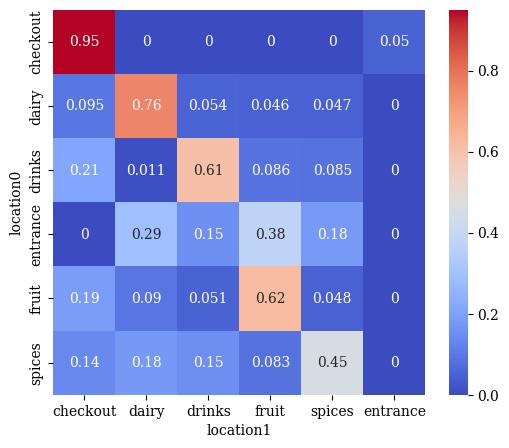

In [28]:
plot_matrix(transition_modified_animation)

/tmp/ipykernel_17309/3586001783.py:28: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')


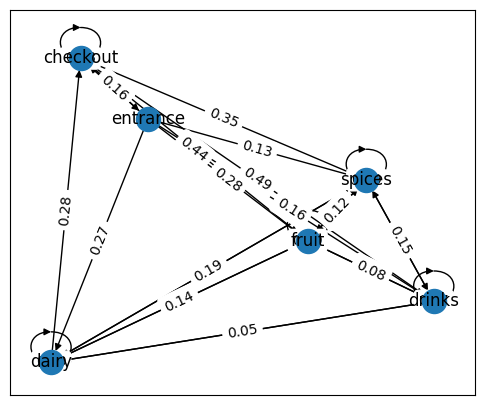

In [29]:
Q = transition_modified_prediction.round(2)
states = ['checkout', 'dairy', 'drinks', 'fruit', 'spices', "entrance"]

# create a function that maps transition probability dataframe
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx, col)] = Q.loc[idx, col]
    return edges

edges_wts = _get_markov_edges(Q)

# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)

# edges represent transition probabilities
for k, v in edges_wts.items():
    if v > 0.0:
        tmp_origin, tmp_destination = k[0], k[1]
        G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for the plot
edge_labels = {(n1, n2): d['label'] for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# write the graph to a DOT file
nx.drawing.nx_pydot.write_dot(G, './markov_data/markov.dot')

# load the graph from the DOT file and save as an image
(graph,) = pydot.graph_from_dot_file('./markov_data/markov.dot')
graph.write_png('./markov_data/markov_diagram.png')


In [30]:
class Customer:

    def __init__(self, name):        
        self.name = name
        self.locations =['checkout', 'dairy', 'drinks', 'fruit', 'spices', "entrance"]
        self.budget=np.random.randint(50,100)
        self.state = "entrance"
        self.recipt=0
        self.produckt_prices={'dairy':[0.5,1,1.5,2,3,4,5], 'drinks':[0.5,1,1.5,2,3,4,5], 'fruit':[1,2,3,4,5], 'spices':[1.5,2,3,4.5,5]}
    
    def next_locatons(self ,matrix):
        self.matrix=matrix
        if self.state!="checkout":
            next_location=np.random.choice(self.locations, p=self.matrix.round(4).loc[self.state])
            print(f"Customers moves from {self.state} to {next_location}")
            self.state = next_location

        else:
            next_location=np.random.choice(self.locations, p=self.matrix.round(4).loc[self.state])
            print(f"Customers moves from {self.state} to {next_location}")
            self.state = next_location

        return next_location

    def is_active(self, next_lacation):
        """Returns True if the customer has not reached the checkout yet."""
        if next_lacation == "checkout":
            return False
        else:
            return True
        
    def financial_status(self):
        if self.state!="checkout":
            price=np.random.choice(list(self.produckt_prices[f"{self.state}"]))
            self.recipt+=price
            print(f"Customer is at {self.state} and continue to shop")
        else:
            print(f"Customer is at {self.state} and {self.recipt} is paid")


In [31]:
Bedo=Customer("4_monday")

In [32]:
a=Bedo.next_locatons(transition_modified_prediction)

Customers moves from entrance to fruit


In [33]:
Bedo.is_active(a)

True

In [34]:
Bedo.financial_status()

Customer is at fruit and continue to shop


In [35]:
customer_sample= ["19_monday", "10_monday", "40_monday"]

In [36]:
number_in_stock={'dairy':500, 'drinks':800, 'fruit':300, 'spices':100}

In [37]:
list(number_in_stock.keys())[0]

'dairy'

In [38]:
number_in_stock[list(number_in_stock.keys())[0]]+=1

In [39]:
number_in_stock

{'dairy': 501, 'drinks': 800, 'fruit': 300, 'spices': 100}

In [40]:
class Supermarket:
    """manages multiple Customer instances that are currently in the market.
    """

    def __init__(self):        
        self.number_in_stock={'dairy':70, 'drinks':100, 'fruit':50, 'spices':30}
        self.customers = []
        self.minutes = 0
        self.revenue=0


    def __repr__(self):
        return ''

    def get_time(self):
        """current time in HH:MM format,
        """
        return None

    def print_customers(self):
        """print all customers with the current time and id in CSV format.
        """
        return self.customers

    def next_minute(self):
        """propagates all customers to the next state.
        """
        return None
    
    def add_new_customers(self):
        """randomly creates new customers.
        """
        self.customers=self.customers.append(Customer.self.name)
        return None

    def remove_exitsting_customers(self):
        """removes every customer that is not active any more.
        """
        return None
    
    def updated_revenue(self):
        if Customer.self.state=="checkout":
            self.revenue=self.revenue+100-Customer.self.budget
        
    
    def in_stock(self):
        if Customer.self.state=="dairy":
            self.number_in_stock[list(self.number_in_stock.keys())[0]]-=1
        elif Customer.self.state=="drinks":
            self.number_in_stock[list(self.number_in_stock.keys())[1]]-=1
        elif Customer.self.state=="fruit":
            self.number_in_stock[list(self.number_in_stock.keys())[2]]-=1
        elif Customer.self.state=="spices":
            self.number_in_stock[list(self.number_in_stock.keys())[3]]-=1
        return self.number_in_stock
    
    def add_stock(self):
        for i in self.number_in_stock.keys():
            if i<10:
                print(f"stock is low at {i}")
                self.number_in_stock[list(self.number_in_stock.keys())[1]]+=30    
    